<a href="https://colab.research.google.com/github/voke-brume/AI-ML/blob/main/BayesMultivariateDiscriminantClassifier/vokeBrumeCS573HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANALYSIS OF BAYES MULTIVARIATE DISCRIMINANT CLASSIFIER** 
by Voke Brume

CS573 - Prof Omid Dezhangi

In [ ]:
# Import required libraries
import os
import copy
import random

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

## **INTRODUCTION**

This is a report on the binary classification of two groups labeled 'R' and 'NR' using Bayes multivariate discriminant classifier. This is similar to Naive Bayes Classifier, however, the difference is Discriminant Analysis treats the likelihood as a whole, learning its multivariate distribution from the training samples directly while Naive Bayes assumes feature independence, and learns the likelihood of each feature independently.

### **FUNCTIONS FOR ANALYSIS**

In [ ]:
# FUNCTIONS FOR ANALYSIS

# Function to save the names of specified file type in a path
# @param: path
# @return: list of files in path
def file_list(path):
  return os.listdir(os.path.abspath(path))

# Function to read .csv file
# @param: path, file_name
# return: read file
def read_csv_file(path, file_name):
  return pd.read_csv(path + file_name)

# Function to concatenate files of specific type in a location
# @param: path, file_list, file_type, axis
# @return: file containing all files in location
def concat_files(path, file_list, file_type, axis):
  # Create temp file to add other files into
  temp_file = pd.DataFrame()
  # Loop through files and concatenate them into master 
  # file for respective class
  for file in file_list:
    if file.endswith(file_type):
      data = pd.read_csv(path + file)
      temp_file = pd.concat([temp_file, data], axis)
  return temp_file

# Function to add new column to the left and fill with 
# values in existing file
# @param: dataframe, label_name, label
# @return: dataframe with inserted column and labels
def add_column(dataframe, label_name, label):
  return dataframe.insert(0, label_name, label)

# Function to drop specified columns in dataframe
# @param: dataframe
# Inplace mutation
def drop_column(dataframe):
  dataframe.drop(dataframe.columns[0], axis=1, inplace=True)
  dataframe.drop(dataframe.iloc[ :, 13 : -10 ], inplace=True, axis=1)

# Function to winsorize specified features
# @param: dataframe, feature_list, lower_end, upper_end
# Inplace mutation
def winsorizer(dataframe, feature_list, lower_end, upper_end):
  for feature in feature_list:
    winsorize(a=dataframe[feature], limits=(lower_end, upper_end), inplace=True)

# Function to add labels
# @param: dataframe
# @returns: labeled daraframe
def add_labels(dataframe):
  temp_list = pd.Series([])
  for i in range(dataframe):
    if i <= 13: temp_list[i]="R"
    else: temp_list[i]="NR"
  return temp_list

# Function to run LDA or QDA on data with label as first column
# @param: classifier, dataframe, label_name
# @return: list of mean of performance measures
def discriminant_classifier(classifier, dataframe, label_name, normalize=False):
  # Declare empty list to store scores
  temp_list = []

  # Define predictor and target variables
  if normalize == True:
    X = np.nan_to_num(preprocessing.normalize(dataframe.iloc[:, 1:], axis=0))
  else: X = np.nan_to_num(dataframe.iloc[:, 1:])
  y = dataframe[label_name]

  # Fit the model
  if classifier == 'lda': model = LinearDiscriminantAnalysis()
  elif classifier == 'qda': model = QuadraticDiscriminantAnalysis()
  else: return 'Wrong classifier specified'

  # Fit model
  model.fit(X, y)

  # Performance measures for LDA
  temp_list.append( round(cross_val_score(model, X, y, cv=10, scoring='accuracy').mean(), 2) )
  temp_list.append( round(cross_val_score(model, X, y, cv=10, scoring='recall').mean(), 2) )
  temp_list.append( round(cross_val_score(model, X, y, cv=10, scoring='precision').mean(), 2) )
  temp_list.append( round(cross_val_score(model, X, y, cv=10, scoring='f1').mean(), 2) )
  # Return list of performance measures
  return temp_list

# Function to calculate the mean of columns in dataframe
# @param: column_names
# @return: mmean of each row to specified floating point
def column_mean(column_names, floating_point):
  return round( column_names.mean(axis=1), floating_point)

# Function to oversample data 
# @param:
# @return:
def oversample_data(dataframe, target_label, class_0, class_1):
  class_0 = dataframe[dataframe[target_label] == class_0]
  class_1 = dataframe[dataframe[target_label] == class_1]
  class_0 = class_0.sample(len(class_1),replace=True)
  dataframe = pd.concat([class_0, class_1], axis=0, ignore_index=True)
  return dataframe

# Function to visualize data using PCA
# @param: dataframe, target_label, and comp_number
# @result: dataframe containing specified number of components
def pca(dataframe, target_label, comp_number):
  # Save feature names of data
  feature_list = list(dataframe.columns[1:])
  # Seperate target and features
  # Numpy array of values
  x = dataframe.loc[:, feature_list].values
  # Array of target labels
  y = dataframe.loc[:,[target_label]].values
  # Data standardization
  x = StandardScaler().fit_transform(x)
  # Rename standardized columns
  pd.DataFrame(data = x, columns = feature_list)
  # Initialize pca object with component(s)
  pca = PCA(n_components=comp_number)
  # Fit features to pca
  principalComponents = pca.fit_transform(x)
  # Add names of pca columns into list
  col_names = []
  for i in range(comp_number):
    col_names.append( 'Principal component ' + str(i+1) )
  # Create dataframe to save and label components
  principalDf = pd.DataFrame(data = principalComponents
             , columns = col_names)
  # Add target labels 
  add_column(principalDf, 'Target', y)
  # Return principal components as dataframe and explained variance
  return principalDf, pca.explained_variance_ratio_.sum() * 100

# Function to visualize PCA components
# @param: dataframe, total_var, label, and dimension
# @result: xD visualization of data
def visualize_xD(dataframe, total_var, label, dimension):
  # Visualize 2D PCA
  if dimension == 2:
    fig = px.scatter(dataframe, x=dataframe.columns[1], y=dataframe.columns[2], color=dataframe[label], title=f'2 PCA Total Explained Variance: {total_var:.2f}%')
    fig.show()
  # Visualize 3D PCA
  elif dimension == 3:
    fig = px.scatter_3d(
        dataframe, x=dataframe.columns[1], y=dataframe.columns[2], z=dataframe.columns[3], color=dataframe['Target'],
        title=f'3 PCA Total Explained Variance: {total_var:.2f}%',
        labels={dataframe.columns[1]: 'PC 1', dataframe.columns[2]: 'PC 2', dataframe.columns[3]: 'PC 3'}
    )
    fig.show()

## **DATA**

The data consists of multiple .csv files  differentiated into 'R' and 'NR" classes. Each .csv file belongs to a subject and contains multiple time series samples. These files are read in and preprocessed according to their statistical attributes before being used for discriminant analysis.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **DATA INVESTIGATION AND VISUALIZATION**

This section shows investigation and visualization of the data to determine the best approaches for preprocessing. The seperation of the data into multiple files makes it difficult to understand the inter-relationship between the data. To aid this investigation, the files are concatenated into one file, after which their spread is then analysed using visualization tools. 

For this analysis, columns labelled Morning_Question1 through Afternoon_Question7 may be referred to as columns B-N and columns labelled HR_mean through Stress_Ku may be referred to as columns IQ-IZ.

#### **INVESTIGATION**

The data files are read in and concatenated into master files. The master files are then inspected to ensure the process went well and the resulting master files do not contain impurities such as null values.

In [ ]:
# Save path for repetitive use
path_R = "/content/drive/Othercomputers/myPCWindows/schoolStuff [D]/CS573/assignments/assignment01/Data/Data/Opioid/ChunkedData_R/"
path_NR = "/content/drive/Othercomputers/myPCWindows/schoolStuff [D]/CS573/assignments/assignment01/Data/Data/Opioid/chunkedData_NR/"

In [ ]:
# Examine a file of class R
read_csv_file(path_R, 'Daily_2009_S2.csv')

,Date,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-03-12,1,4,5,4,2,5,5,5,3,...,88.145658,136.424015,11.680069,0.040435,-0.403747,49.965318,706.580186,26.581576,-0.248666,-1.243101
1,2020-03-13,1,4,5,4,2,5,5,5,3,...,77.903041,109.565154,10.467337,0.388084,0.213380,23.723333,310.729220,17.627513,1.404040,1.396207
2,2020-03-14,1,4,5,4,2,5,5,5,3,...,78.847717,90.664371,9.521784,0.464439,-0.090565,25.232787,300.416027,17.332514,0.909671,0.172335
3,2020-03-15,1,4,5,4,2,5,5,5,3,...,80.211872,96.761825,9.836759,0.615054,-0.207039,28.422481,401.544551,20.038577,1.389644,0.904045
4,2020-03-16,1,4,5,4,2,5,5,5,3,...,79.189117,142.802505,11.950000,0.686743,-0.043474,25.029412,382.973815,19.569717,1.437724,1.565999
5,2020-03-17,1,4,5,4,2,5,5,5,3,...,83.821510,81.834301,9.046231,0.482755,0.438750,37.466667,497.797199,22.311369,0.610208,-0.556770
6,2020-03-18,1,4,5,4,2,5,5,5,3,...,78.942676,72.176805,8.495693,0.715203,0.357507,19.630597,133.072768,11.535717,1.238114,2.082671
7,2020-03-19,1,4,5,4,2,5,5,5,3,...,82.859524,107.352788,10.361119,0.464180,-0.169782,32.730159,449.648011,21.204905,0.637978,-0.578463
8,2020-03-20,1,4,5,4,2,5,5,5,3,...,81.119850,187.465476,13.691803,1.175501,1.557958,20.993127,399.627539,19.990686,1.760056,3.007116
9,2020-03-21,1,4,5,4,2,5,5,5,3,...,80.221151,80.821003,8.990050,0.306884,0.026360,34.027778,530.027157,23.022319,0.441434,-0.953970


In [ ]:
# Examine a file of class NR
read_csv_file(path_NR, 'Daily_2018_S1.csv')

,Date,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-01-03,5,5,5,5,1,5,5,5,5,...,75.374197,118.612123,10.890919,0.755042,-0.250056,20.619497,180.192300,13.423573,2.111799,5.830426
1,2020-01-04,5,5,5,5,1,5,5,5,4,...,75.624222,107.836532,10.384437,0.977850,0.331550,20.294521,66.827049,8.174781,2.022671,10.157793
2,2020-01-05,5,5,5,5,1,5,5,5,5,...,72.265284,108.039325,10.394197,1.106237,0.370972,18.673981,53.006585,7.280562,1.933305,10.941298
3,2020-01-06,5,5,5,5,1,5,5,5,5,...,73.318805,97.603799,9.879463,1.002217,0.203340,19.199396,97.717697,9.885226,1.706116,5.380612
4,2020-01-07,5,5,5,5,1,5,5,5,5,...,74.499740,176.853378,13.298623,0.689050,-0.807611,21.352584,191.070428,13.822823,1.607113,2.534028
5,2020-01-08,5,5,5,5,1,5,5,5,5,...,75.573363,133.098776,11.536844,0.695676,-0.597001,20.084691,149.855549,12.241550,1.644782,3.849945
6,2020-01-09,5,5,5,5,1,5,5,5,5,...,76.055218,140.367913,11.847697,0.422342,-0.890770,23.507299,227.796650,15.092934,1.864462,3.318733
7,2020-01-10,5,5,5,5,1,5,5,5,5,...,76.416918,129.143460,11.364130,0.552697,-0.742907,21.556420,96.630593,9.830086,2.230796,7.041048
8,2020-01-11,5,2,5,5,1,5,5,3,5,...,75.091395,114.924930,10.720305,0.882862,0.085605,21.622711,121.816688,11.037060,1.878599,6.070944
9,2020-01-12,5,5,5,5,1,5,5,5,5,...,74.723216,81.032790,9.001821,0.629424,-0.240900,20.737024,85.680604,9.256382,1.042027,2.800311


The above tables coupled with further investigation showed that each file in class R and NR contain 260 columns which means a master file can be created by concatenating files in respective classes across the 0 axis (columns).

In [ ]:
# Save and print names of all files in directory
file_list_R = file_list(path_R)
file_list_NR = file_list(path_NR)
all_file_list = [file_list(path_R), file_list(path_NR)]
print(file_list_R)
print(file_list_NR)
print(all_file_list)

['Daily_2009_S2.csv', 'Daily_2009_S3.csv', 'Daily_2027_S1.csv', 'Daily_2027_S2.csv', 'Daily_2027_S3.csv', 'Daily_2060_S1.csv', 'Daily_2060_S2.csv', 'Daily_2060_S3.csv', 'Daily_2061_S1.csv', 'Daily_2061_S2.csv', 'Daily_2061_S3.csv', 'Daily_2088_S2.csv', 'Daily_2088_S3.csv', 'Daily_2009_S1.csv']
['Daily_2002_S2.csv', 'Daily_2002_S3.csv', 'Daily_2018_S1.csv', 'Daily_2018_S2.csv', 'Daily_2018_S3.csv', 'Daily_2029_S1.csv', 'Daily_2029_S2.csv', 'Daily_2029_S3.csv', 'Daily_2052_S1.csv', 'Daily_2052_S2.csv', 'Daily_2052_S3.csv', 'Daily_2057_S1.csv', 'Daily_2057_S2.csv', 'Daily_2057_S3.csv', 'Daily_2065_S1.csv', 'Daily_2065_S2.csv', 'Daily_2065_S3.csv', 'Daily_2068_S1.csv', 'Daily_2068_S2.csv', 'Daily_2068_S3.csv', 'Daily_2080_S1.csv', 'Daily_2080_S2.csv', 'Daily_2080_S3.csv', 'Daily_2087_S2.csv', 'Daily_2087_S3.csv', 'Daily_2002_S1.csv']
[['Daily_2009_S2.csv', 'Daily_2009_S3.csv', 'Daily_2027_S1.csv', 'Daily_2027_S2.csv', 'Daily_2027_S3.csv', 'Daily_2060_S1.csv', 'Daily_2060_S2.csv', 'Daily_20

In [ ]:
# Concatenate all files into a master file for each class R
master_file_R = concat_files(path_R, file_list_R, '.csv', 0)
master_file_R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


,Date,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-03-12,1,4,5,4,2,5,5,5,3,...,88.145658,136.424015,11.680069,0.040435,-0.403747,49.965318,706.580186,26.581576,-0.248666,-1.243101
1,2020-03-13,1,4,5,4,2,5,5,5,3,...,77.903041,109.565154,10.467337,0.388084,0.213380,23.723333,310.729220,17.627513,1.404040,1.396207
2,2020-03-14,1,4,5,4,2,5,5,5,3,...,78.847717,90.664371,9.521784,0.464439,-0.090565,25.232787,300.416027,17.332514,0.909671,0.172335
3,2020-03-15,1,4,5,4,2,5,5,5,3,...,80.211872,96.761825,9.836759,0.615054,-0.207039,28.422481,401.544551,20.038577,1.389644,0.904045
4,2020-03-16,1,4,5,4,2,5,5,5,3,...,79.189117,142.802505,11.950000,0.686743,-0.043474,25.029412,382.973815,19.569717,1.437724,1.565999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,2020-01-27,1,3,5,4,2,5,5,5,3,...,76.456479,104.888479,10.241508,0.724969,0.040535,19.504615,244.491491,15.636224,1.300658,1.695497
25,2020-01-28,2,4,5,4,2,5,5,5,4,...,76.531863,64.199011,8.012429,0.488844,0.031401,26.023810,299.312864,17.300661,1.312268,1.470618
26,2020-01-29,1,4,5,4,2,5,5,5,3,...,79.589139,79.513839,8.917053,0.671970,0.512182,27.358065,381.835776,19.540619,0.902714,-0.092764
27,2020-01-30,1,3,5,4,2,5,5,4,4,...,77.991492,93.701039,9.679930,0.410115,-0.587282,27.320000,411.467507,20.284662,0.959439,-0.014027


In [ ]:
# The info() function is used to get a quick description of the data and the number of null values.
master_file_R.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 0 to 28
Columns: 260 entries, Date to Stress_ku
dtypes: float64(246), int64(13), object(1)
memory usage: 621.9+ KB


In [ ]:
# Concatenate all files into a master file for each class NR
master_file_NR = concat_files(path_NR, file_list_NR, '.csv', 0)
master_file_NR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


,Date,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-03-12,4,4,4,4,2,4,4,4,4,...,93.297082,137.042961,11.706535,0.016681,0.092154,66.404762,442.676582,21.039881,-1.450083,1.842926
1,2020-03-13,4,4,4,4,2,4,4,4,4,...,94.150870,232.050396,15.233200,-0.517867,-0.266539,58.510417,826.438534,28.747844,-0.439320,-1.196915
2,2020-03-14,4,4,4,4,2,4,4,4,4,...,94.792325,135.490035,11.640019,0.314420,0.791775,63.583120,430.961663,20.759616,-0.771836,0.514077
3,2020-03-15,2,4,4,4,2,4,4,4,4,...,79.202372,36.777814,6.064471,1.867361,6.309211,25.727660,95.968249,9.796339,2.149901,7.121221
4,2020-03-16,4,4,4,4,2,4,4,4,4,...,80.812599,80.228200,8.957020,0.301850,1.425545,27.873351,259.322542,16.103495,0.701707,0.358687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,2020-01-27,4,4,4,4,2,4,4,4,4,...,85.070498,78.477141,8.858732,0.565347,0.959000,36.458204,380.553372,19.507777,0.678762,-0.320283
25,2020-01-28,4,4,4,4,2,4,4,4,4,...,78.108873,75.195335,8.671524,0.357057,-0.443991,23.019126,238.325661,15.437800,1.320018,1.317603
26,2020-01-29,4,4,4,4,2,4,4,4,4,...,81.816045,97.868417,9.892847,1.001666,1.448900,29.306818,339.694768,18.430810,1.194194,0.631938
27,2020-01-30,4,4,4,4,2,4,4,4,4,...,87.328356,201.916999,14.209750,0.103016,-0.932049,43.188011,770.633954,27.760295,0.218189,-1.534136


In [ ]:
# The info() function is used to get a quick description of the data and the number of null values.
master_file_NR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 28
Columns: 260 entries, Date to Stress_ku
dtypes: float64(244), int64(15), object(1)
memory usage: 1.4+ MB


The above tables show that after concatenation, the master file containing all values for class R has 305 rows and 260 columns while class NR master file has 699 rows and 260 columns. Also, their individual information (.info()) show they do not contain null values.

#### **VISUALIZATION**

In this subsection, the master files are visualized and examined to determine the best statistical tools to use in aggregating individual subjects before the preprocessing. To aid visualization, labels are added to the master files, then both master files for class R and NR are concatenated into one file. The concatenated file is then visualized.

In [ ]:
concat_master_files = pd.concat([master_file_R, master_file_NR])

drop_column(concat_master_files)

concat_master_files

,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,Afternoon_Question4,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,1,4,5,4,2,5,5,5,3,2,...,88.145658,136.424015,11.680069,0.040435,-0.403747,49.965318,706.580186,26.581576,-0.248666,-1.243101
1,1,4,5,4,2,5,5,5,3,2,...,77.903041,109.565154,10.467337,0.388084,0.213380,23.723333,310.729220,17.627513,1.404040,1.396207
2,1,4,5,4,2,5,5,5,3,2,...,78.847717,90.664371,9.521784,0.464439,-0.090565,25.232787,300.416027,17.332514,0.909671,0.172335
3,1,4,5,4,2,5,5,5,3,2,...,80.211872,96.761825,9.836759,0.615054,-0.207039,28.422481,401.544551,20.038577,1.389644,0.904045
4,1,4,5,4,2,5,5,5,3,2,...,79.189117,142.802505,11.950000,0.686743,-0.043474,25.029412,382.973815,19.569717,1.437724,1.565999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,4,4,4,4,2,4,4,4,4,4,...,85.070498,78.477141,8.858732,0.565347,0.959000,36.458204,380.553372,19.507777,0.678762,-0.320283
25,4,4,4,4,2,4,4,4,4,4,...,78.108873,75.195335,8.671524,0.357057,-0.443991,23.019126,238.325661,15.437800,1.320018,1.317603
26,4,4,4,4,2,4,4,4,4,4,...,81.816045,97.868417,9.892847,1.001666,1.448900,29.306818,339.694768,18.430810,1.194194,0.631938
27,4,4,4,4,2,4,4,4,4,4,...,87.328356,201.916999,14.209750,0.103016,-0.932049,43.188011,770.633954,27.760295,0.218189,-1.534136


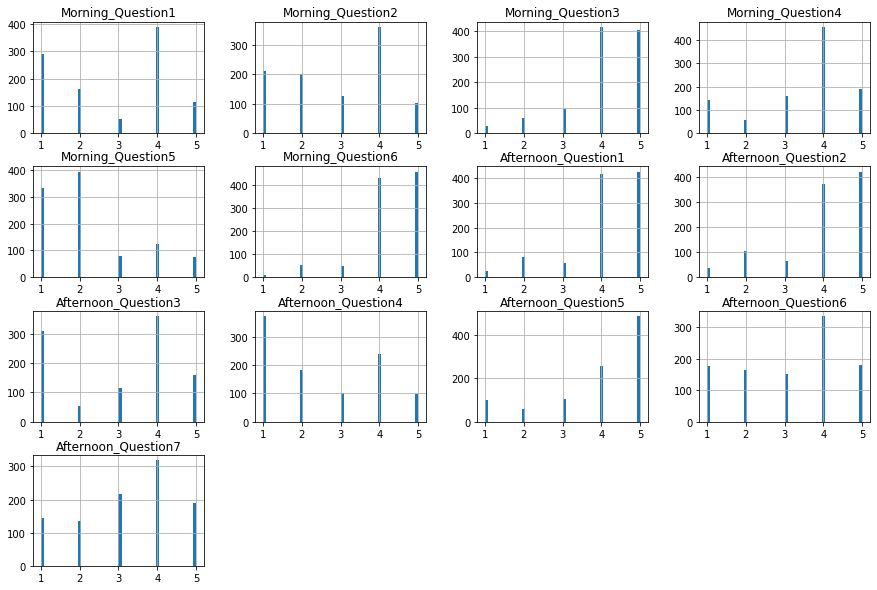

In [ ]:
# Pairplot of columns B-N
concat_master_files.iloc[ :,0:13 ].hist(bins=50, figsize=(15,10))
plt.show()

The above plots show the distribution of values in columns B-N. It can be observed that there is high variation in the frequency of the values. This indicates that mean as a measure of central tendency will misrepresent the data because it'll be pulled towards outliers. Therefore, this analysis will be using the median of each of column in the above plot to aggragate the values of each subject.

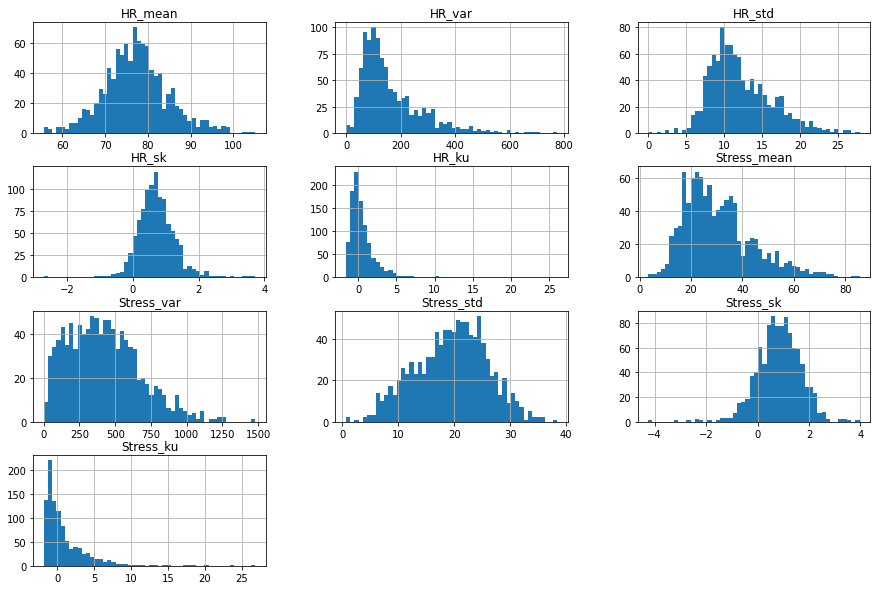

In [ ]:
# Pairplot of columns IQ - IZ
concat_master_files.iloc[ :,13: ].hist(bins=50, figsize=(15,10))
plt.show()

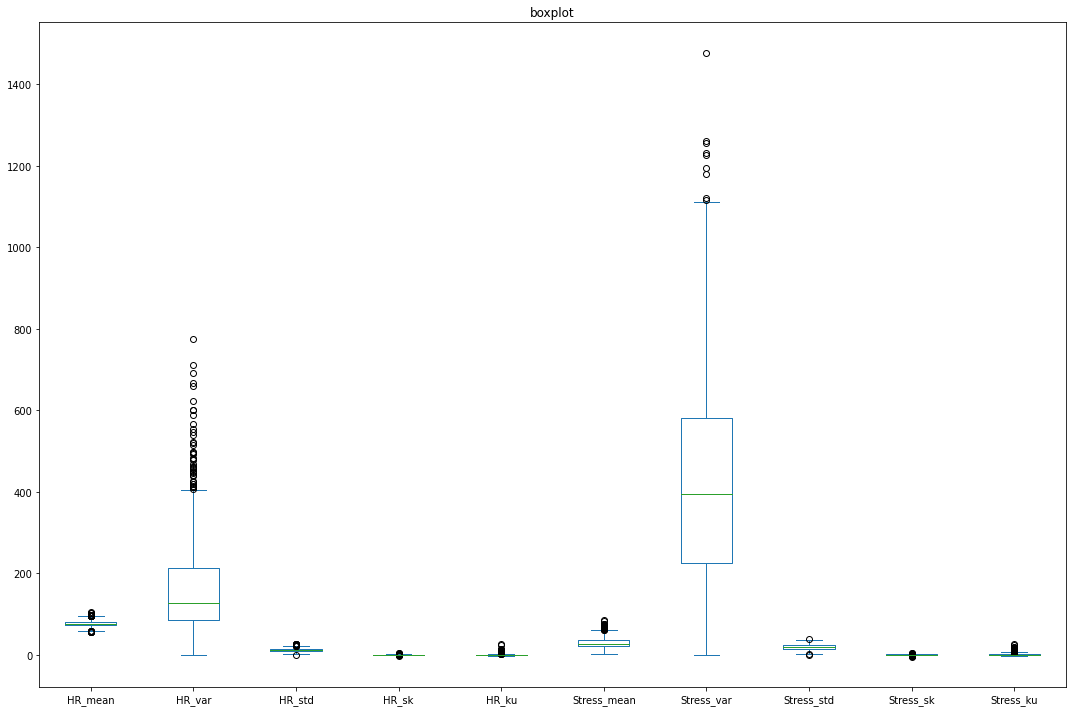

In [ ]:
# Box plot to check the presence of outliers in the dataset
# Set the figure size
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = concat_master_files[['HR_mean', 'HR_var', 'HR_std', 'HR_sk', 'HR_ku', 'Stress_mean', 'Stress_var', 'Stress_std', 'Stress_sk', 'Stress_ku']].plot(kind='box', title='boxplot')

#plt.boxplot(concat_master_files.iloc[ :,14 ])
#plt.title('Boxplot of Columns IQ-IZ')
plt.show()

The histogram of columns IQ - IZ show varying distribution of their values. Columns like HR_mean and Stress_std show gausian distribution while others such as HR_ku, Stress_ku, and Stress_var show skewness of their values towards lower values. Futhermore, the boxplot above shows all columns contain outliers either on the upper end or both upper and lower ends, with the upper outliers being more pronounced. 

These outliers may be caused by error in data collection or may be a result of plotting values from different test subjects together. Therefore, both mean and winsorized mean would be used on the data set and the best result will be chosen for analysis.

**Winsorized mean** is a method of averaging that initially replaces the smallest and largest values with the observations closest to them. This is done to limit the effect of outliers or abnormal extreme values, or outliers, on the calculation. After replacing the values, the arithmetic mean formula is then used to calculate the winsorized mean.

### **DATA PREPROCESSING**

The data is split into two dataframes containing information for columns B-N and IQ-IZ. The average of each column B-N is then computed using median and the average of columns IQ-IZ is computed using both mean and winsorized mean.

In [ ]:
# Create master files and counter
all_files_bn = pd.DataFrame()
all_files_qz_mean = pd.DataFrame()
all_files_qz_win_mean = pd.DataFrame()
i = 0

# List of features in columns IQ-IZ for winsorizer and to plot graph
feature_list = list(concat_master_files.columns[13:])

# Preprocessing pipeline
while (i <= 1):
  for file in all_file_list[i]:
    if file.endswith('.csv'):
      # Creat temp file
      if i is 0:
        temp_file = read_csv_file(path_R, file)
      else: 
        temp_file = read_csv_file(path_NR, file)

      # Drop unwanted column
      drop_column(temp_file)

      # Split columns into two files
      file_BN = temp_file[ temp_file.columns[0:13] ]
      file_QZ = temp_file[ temp_file.columns[13:] ]

      # Use median to aggregate columns B-N and mean for columns IQ-IZ
      all_files_bn = all_files_bn.append(file_BN.median(), ignore_index = True)
      #print( type(file_BN.median()) )

      # Mean before winsorization
      all_files_qz_mean = all_files_qz_mean.append(file_QZ.mean(), ignore_index = True)

      # Values in columns IQ-IZ are winsorized, then the mean is found
      file_QZ_copy = copy.deepcopy(file_QZ)
      winsorizer(file_QZ_copy, feature_list, 0.16, 0.16)
      all_files_qz_win_mean = all_files_qz_win_mean.append(file_QZ_copy.mean(), ignore_index = True)

  # Increment i      
  i += 1

In [ ]:
# Averaged and labeled data for columns B-N
add_column(all_files_bn, 'Label', add_labels(40))
all_files_bn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Label,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,Afternoon_Question4,Afternoon_Question5,Afternoon_Question6,Afternoon_Question7
0,R,1.0,4.0,5.0,4.0,2.0,5.0,5.0,5.0,3.0,2.0,5.0,4.0,3.0
1,R,1.0,4.0,5.0,4.0,2.0,5.0,5.0,5.0,3.0,2.0,5.0,4.0,3.0
2,R,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
3,R,4.0,2.0,4.0,1.0,2.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,4.0
4,R,4.0,5.0,4.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0,2.0,4.0
5,R,2.0,2.0,5.0,4.0,2.0,5.0,5.0,5.0,4.0,4.0,5.0,3.0,2.0
6,R,2.0,2.0,3.0,4.0,2.0,4.0,3.0,3.0,4.0,4.0,5.0,4.0,1.0
7,R,2.0,2.0,3.0,4.0,2.0,4.0,4.0,3.0,4.0,4.0,5.0,3.0,1.0
8,R,4.0,2.0,4.0,3.5,2.0,4.0,4.0,4.0,4.0,3.0,4.0,2.0,2.0
9,R,2.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0


In [ ]:
# Averaged and labeled data for columns IQ-IZ using mean
add_column(all_files_qz_mean, 'Label', add_labels(40))
all_files_qz_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Label,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,R,78.755302,96.654404,9.592202,0.547718,0.093114,27.938666,375.588732,18.570224,0.884779,0.856429
1,R,78.145788,85.912121,9.195755,0.607978,0.401042,25.338857,317.837071,17.556508,1.125738,1.080880
2,R,77.458412,153.355724,12.230244,1.079538,1.357487,28.654675,419.623256,20.241864,1.163639,0.850771
3,R,80.127725,99.405597,9.735538,0.771577,0.472752,27.296821,427.179487,20.175128,1.067481,0.798046
4,R,75.671044,217.358858,14.022864,1.102250,1.143081,31.225482,616.333657,24.128994,0.790242,-0.119719
5,R,82.103589,225.908191,14.490706,1.032999,1.058226,30.117192,428.068516,20.022260,1.015493,0.773932
6,R,74.539412,258.342542,15.626514,0.873997,0.423285,28.658744,575.018581,23.584929,0.966425,0.224873
7,R,79.155946,205.498687,14.074432,1.099545,1.282880,33.185052,476.054693,21.436647,0.818107,0.288268
8,R,77.485337,206.716780,13.962574,0.804257,0.207425,37.324784,536.870085,22.402838,0.514166,-0.672633
9,R,75.952489,247.694773,14.946150,1.043517,2.221792,30.908915,555.584474,22.061094,1.005969,0.657082


In [ ]:
# Averaged and labeled data for columns IQ-IZ using winsorized mean
add_column(all_files_qz_win_mean, 'Label', add_labels(40))
all_files_qz_win_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Label,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,R,78.435583,97.047490,9.779066,0.561912,0.045075,27.032226,367.278783,18.847545,0.992673,0.636532
1,R,78.038922,85.815871,9.210404,0.603103,0.337782,24.646563,307.141985,17.384052,1.153423,1.018142
2,R,77.658259,151.890416,12.247024,1.083655,1.283753,28.399853,411.730050,20.145746,1.173352,0.786050
3,R,79.964001,96.778177,9.722701,0.781680,0.412092,26.635210,418.434490,20.186947,1.065914,0.533693
4,R,75.503474,209.471860,14.005251,1.096614,1.028516,30.168520,608.724122,24.240947,0.819127,-0.257581
5,R,81.665511,226.934904,14.652034,1.041679,0.973981,28.964206,410.506870,19.789912,1.029555,0.799029
6,R,74.404732,256.437388,15.714872,0.857706,0.254809,26.902464,577.039214,23.742521,0.940688,-0.204292
7,R,78.973655,208.813181,14.278275,1.098301,1.169377,32.386702,465.775051,21.339224,0.858544,0.294605
8,R,77.528519,194.459754,13.698290,0.783635,0.032062,37.072943,532.203390,22.541569,0.532824,-0.739569
9,R,76.602770,240.364935,15.247242,0.895601,0.305723,31.819085,561.027902,22.970262,0.999098,0.254764


The results of the mean and winsorized mean of columns IQ-IZ are ploted and their skewness is indicated.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


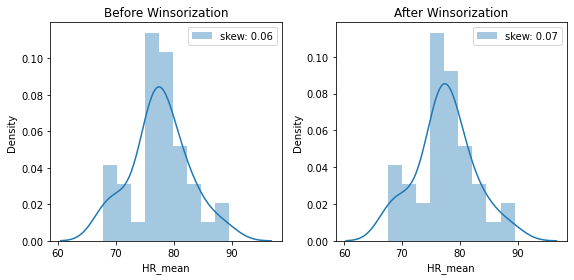

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


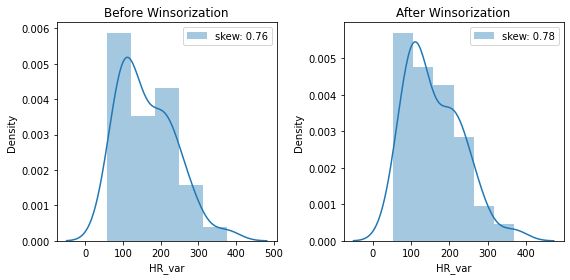

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


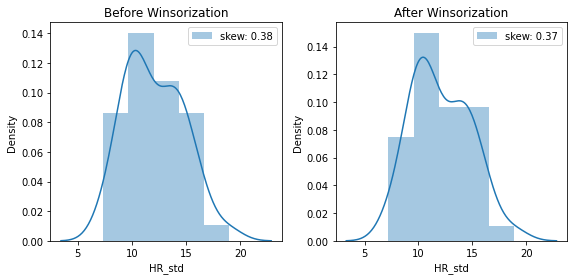

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


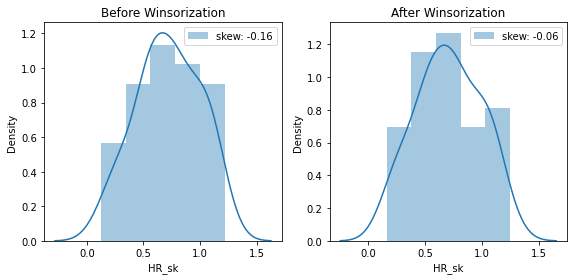

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


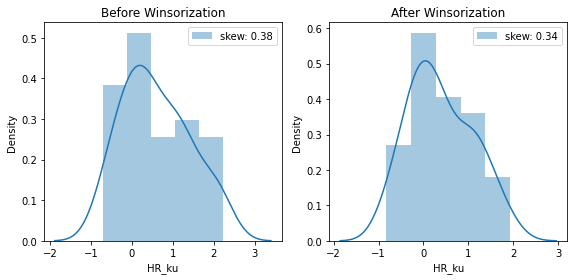

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


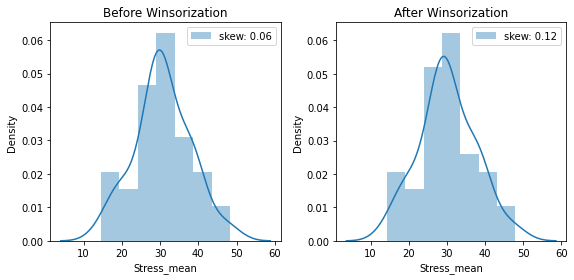

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


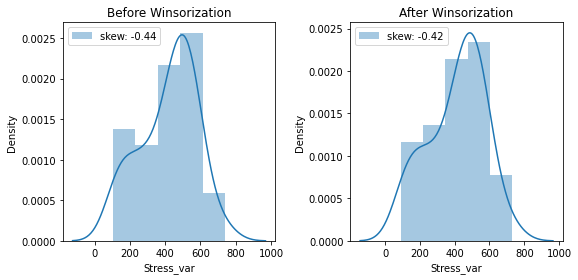

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


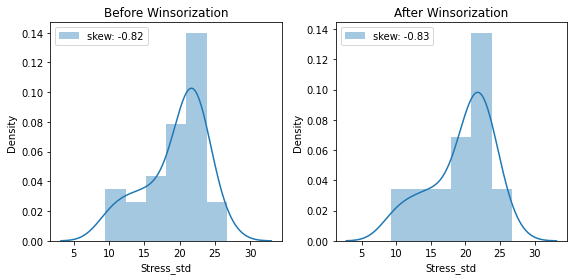

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


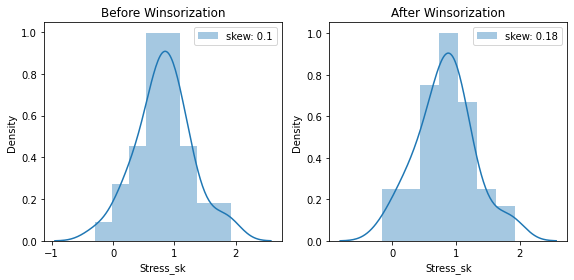

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


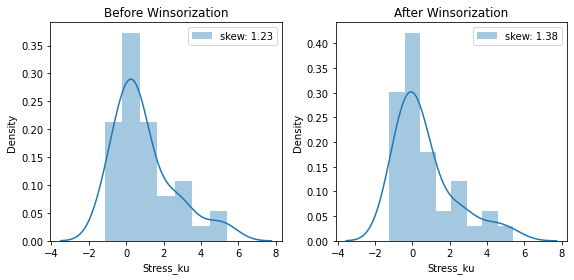

In [ ]:
# Plot results of mean versus winsorized mean
for feature in feature_list:
    plt.figure(figsize=(16,4))
    
    plt.subplot(141)
    sns.distplot(all_files_qz_mean[feature], label="skew: " + str(np.round(all_files_qz_mean[feature].skew(),2)))
    plt.title('Before Winsorization')
    plt.legend()
    
    plt.subplot(142)
    sns.distplot(all_files_qz_win_mean[feature], label="skew: " + str(np.round(all_files_qz_win_mean[feature].skew(),2)))
    plt.title('After Winsorization')
    plt.legend()
    
    plt.show()

After winsorizing the data with different percentages ranging from 10% - 25%, it was observed that the sample mean produced the least amount of skew. This suggests that outliers observed in previous plots may have been as a result of plotting values from different test subjects together. These outliers are less pronounced when averaged within individual subject's data.

Also, dummy variables were created to represent the target feature 'Label' as numerical values of zero and one. 

**R = 0 and NR = 1**

In [ ]:
# Dictionary for binary values to the target feature 'Label'
cleanup_nums = {"Label":     {"R": 0, "NR": 1}}

# Convert the values to numbers using replace
all_files_bn = all_files_bn.replace(cleanup_nums)
all_files_bn

,Label,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,Afternoon_Question4,Afternoon_Question5,Afternoon_Question6,Afternoon_Question7
0,0,1.0,4.0,5.0,4.0,2.0,5.0,5.0,5.0,3.0,2.0,5.0,4.0,3.0
1,0,1.0,4.0,5.0,4.0,2.0,5.0,5.0,5.0,3.0,2.0,5.0,4.0,3.0
2,0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
3,0,4.0,2.0,4.0,1.0,2.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,4.0
4,0,4.0,5.0,4.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0,2.0,4.0
5,0,2.0,2.0,5.0,4.0,2.0,5.0,5.0,5.0,4.0,4.0,5.0,3.0,2.0
6,0,2.0,2.0,3.0,4.0,2.0,4.0,3.0,3.0,4.0,4.0,5.0,4.0,1.0
7,0,2.0,2.0,3.0,4.0,2.0,4.0,4.0,3.0,4.0,4.0,5.0,3.0,1.0
8,0,4.0,2.0,4.0,3.5,2.0,4.0,4.0,4.0,4.0,3.0,4.0,2.0,2.0
9,0,2.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0


In [ ]:
# Convert the values to numbers using replace
all_files_qz_mean = all_files_qz_mean.replace(cleanup_nums)
all_files_qz_mean

,Label,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,0,78.755302,96.654404,9.592202,0.547718,0.093114,27.938666,375.588732,18.570224,0.884779,0.856429
1,0,78.145788,85.912121,9.195755,0.607978,0.401042,25.338857,317.837071,17.556508,1.125738,1.080880
2,0,77.458412,153.355724,12.230244,1.079538,1.357487,28.654675,419.623256,20.241864,1.163639,0.850771
3,0,80.127725,99.405597,9.735538,0.771577,0.472752,27.296821,427.179487,20.175128,1.067481,0.798046
4,0,75.671044,217.358858,14.022864,1.102250,1.143081,31.225482,616.333657,24.128994,0.790242,-0.119719
5,0,82.103589,225.908191,14.490706,1.032999,1.058226,30.117192,428.068516,20.022260,1.015493,0.773932
6,0,74.539412,258.342542,15.626514,0.873997,0.423285,28.658744,575.018581,23.584929,0.966425,0.224873
7,0,79.155946,205.498687,14.074432,1.099545,1.282880,33.185052,476.054693,21.436647,0.818107,0.288268
8,0,77.485337,206.716780,13.962574,0.804257,0.207425,37.324784,536.870085,22.402838,0.514166,-0.672633
9,0,75.952489,247.694773,14.946150,1.043517,2.221792,30.908915,555.584474,22.061094,1.005969,0.657082


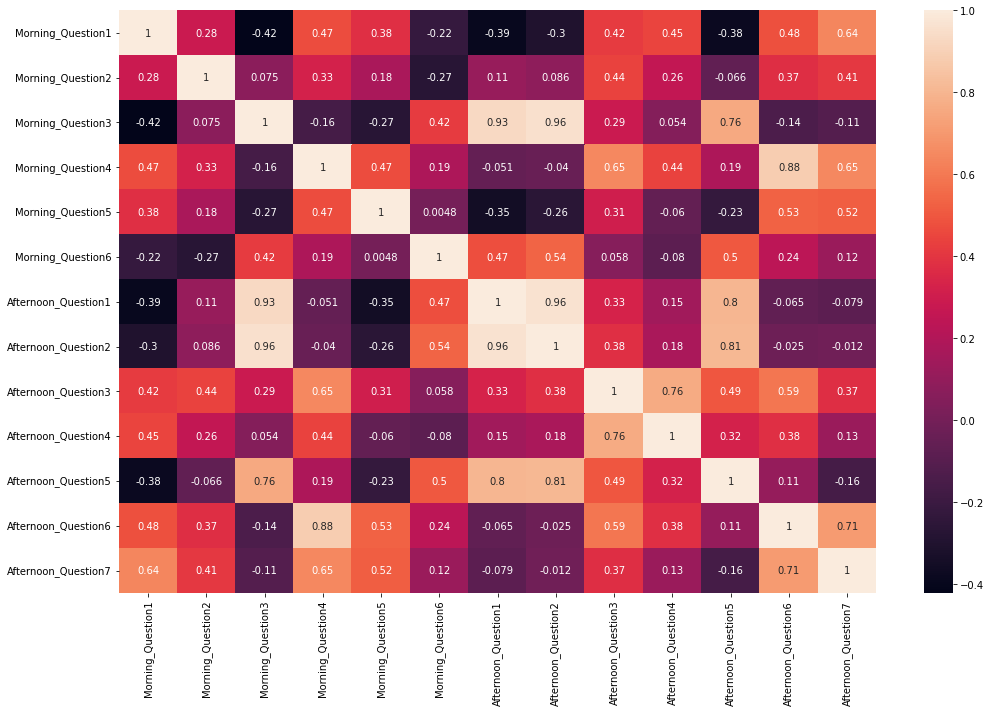

In [ ]:
# checking correlation of columns B-N using heatmap
ax = sns.heatmap(all_files_bn.iloc[:, 1:].corr(), annot=True)

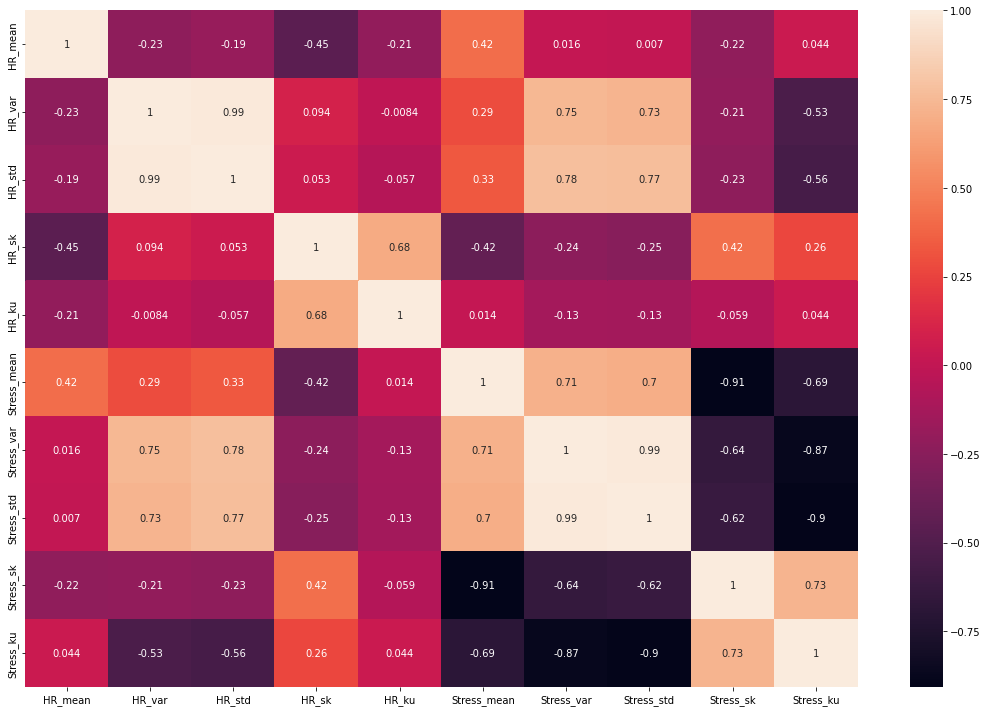

In [ ]:
# checking correlation of columns IQ-IZ using heatmap
ax = sns.heatmap(all_files_qz_mean.iloc[:, 1:].corr(), annot=True)

The above correlation matrices for each column group B-N and IQ-IZ shows the correlation between their features. Correlation is a statistical measure that expresses the extent to which two variables are linearly related. The plots show that the features in columns B-N show higher correlation than features in columns IQ-IZ. This may be dure to their values being integers within a very short range. No column is dropped for this analysis.

Also, the presence of fourteen(14) samples for class R and twenty-six(26) for class NR is an imbalance that is addressed. To better balance the data, samples of class R are oversampled so they have equal number of samples with class NR.

In [ ]:
# Oversample class R to reduce imbalance
all_files_bn = oversample_data(all_files_bn, 'Label', 0, 1)
all_files_qz_mean = oversample_data(all_files_qz_mean, 'Label', 0, 1)

In [ ]:
# Dataframe to save all results of models
# Create data frame from csv file
bayes_results = pd.DataFrame()
bayes_results.insert(0, 'Performance Measures', ['Accuracy', 'Recall', 'Precision', 'F1'])

# Make performance measures the index of dataframe
#bayes_results.set_index("Performance Measures", inplace = True)

## **LDA AND QDA**

Linear Discriminat Analysis(LDA) and Quadratic Discriminant Analysis(QDA) are both improvements on Naive Bayes analysis. LDA represents Cases One or Two where the assumptions is no correlation between features or covariance of all classes are identical but arbituary. QDA represents Case 3 where the assumption is the covariance matrices of the classes are different for each category. The dataset used in this analysis is a time series dataset so the **hypothesis** is QDA should perform better than LDA because covariance matrices of the classes should be different for each category. Both LDA and QDA are used on the dataset and their results compared so the **null-hypothesis** is either discarded or accepted.

Cross-validation is used to generate the performance measures for this analysis due to the low amount of samples available for its high dimensionality.

### **LINEAR DISCRIMINANT ANALYSIS**

#### **COLUMNS B-N**

In [ ]:
# LDA for columns B-N without normalization
# Add results to result-dataframe
#print( oversample_data(all_files_bn, 'Label', 'R', 'NR') )
bayes_results['LDA Columns B-N'] = discriminant_classifier('lda', all_files_bn, 'Label')
bayes_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Performance Measures,LDA Columns B-N
0,Accuracy,0.73
1,Recall,0.77
2,Precision,0.70
3,F1,0.70


#### **COLUMNS IQ-IZ**

In [ ]:
# LDA for columns IQ-IZ
# Add results to dataframe
bayes_results['LDA Columns IQ-IZ'] = discriminant_classifier('lda', all_files_qz_mean, 'Label')
bayes_results

,Performance Measures,LDA Columns B-N,LDA Columns IQ-IZ
0,Accuracy,0.73,0.81
1,Recall,0.77,0.72
2,Precision,0.70,0.94
3,F1,0.70,0.78


#### **LDA AVERAGE**

In [ ]:
# Add column of average results for LDA
bayes_results['LDA Mean'] = column_mean(bayes_results.loc[:, :], 2)
bayes_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Performance Measures,LDA Columns B-N,LDA Columns IQ-IZ,LDA Mean
0,Accuracy,0.73,0.81,0.77
1,Recall,0.77,0.72,0.74
2,Precision,0.70,0.94,0.82
3,F1,0.70,0.78,0.74


### **QUADRATIC DISCRIMINANT ANALYSIS**

#### **COLUMNS B-N**

In [ ]:
# QDA for columns B-N
# Add results to dataframe
bayes_results['QDA Columns B-N'] = discriminant_classifier('qda', all_files_bn, 'Label')
bayes_results

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

,Performance Measures,LDA Columns B-N,LDA Columns IQ-IZ,LDA Mean,QDA Columns B-N
0,Accuracy,0.73,0.81,0.77,0.90
1,Recall,0.77,0.72,0.74,0.90
2,Precision,0.70,0.94,0.82,0.83
3,F1,0.70,0.78,0.74,0.86


#### **COLUMNS IQ-IZ**

In [ ]:
# LDA for columns IQ-IZ
# Add results to dataframe
bayes_results['QDA Columns IQ-IZ'] = discriminant_classifier('qda', all_files_qz_mean, 'Label')
bayes_results

,Performance Measures,LDA Columns B-N,LDA Columns IQ-IZ,LDA Mean,QDA Columns B-N,QDA Columns IQ-IZ
0,Accuracy,0.73,0.81,0.77,0.90,0.86
1,Recall,0.77,0.72,0.74,0.90,0.95
2,Precision,0.70,0.94,0.82,0.83,0.84
3,F1,0.70,0.78,0.74,0.86,0.87


#### **QDA AVERAGE**

In [ ]:
# Add column of average results for LDA
col = bayes_results.iloc[:, 3:]
bayes_results['QDA Mean'] = column_mean(bayes_results.iloc[:, 3:], 2)
bayes_results

,Performance Measures,LDA Columns B-N,LDA Columns IQ-IZ,LDA Mean,QDA Columns B-N,QDA Columns IQ-IZ,QDA Mean
0,Accuracy,0.73,0.81,0.77,0.90,0.86,0.84
1,Recall,0.77,0.72,0.74,0.90,0.95,0.86
2,Precision,0.70,0.94,0.82,0.83,0.84,0.83
3,F1,0.70,0.78,0.74,0.86,0.87,0.82


## **RESULTS**

This section handles the comparison and analysis of results from LDA and QDA. This is done by comparing results from performance measures that are computed from a **confusion matrix**. A confusion matrix is made up of calculations computed from four values which are:

**True Positive:** Number of class A that were correctly classified by model

**True Nagative:** Number of class B that were correctly classified by model

**False Positive:** Number of class A that were misclassified by model as class B

**False Nagative:** Number of class B that were misclassified by model as class A

These four values are then used to compute performance measures for this analysis. The performance measures used are accuracy, recall, presision, and F1.

**ACCURACY:** Accuracy returns the proportion of correct predictions. The formula is given as: 

            (TP + TN)/(TP + TN + FP + FN)

**RECALL:** The recall of a model returns the proportion of positive values correctly predicted. The formula is given as: 

            TP/(TP + FN)

**PRECISON:** The precision of a model returns the proportion of true positives among all the values predicted as positive. The formula is given as: 

            TP/(TP + FP)

**F1:** This measure represents the harmonic mean of precision and recall. It is very good for comparing classifiers. The formula is given as: 

            (2 * Precision)/(Precision + Recall)

### **TABLE OF RESULTS FOR LDA AND QDA**

In [ ]:
bayes_results

,LDA Columns B-N,LDA Columns IQ-IZ,LDA Mean,QDA Columns B-N,QDA Columns IQ-IZ,QDA Mean
Performance Measures,,,,,,
Accuracy,0.77,0.83,0.80,0.87,0.84,0.86
Recall,0.67,0.70,0.68,0.90,0.97,0.94
Precision,0.72,0.97,0.84,0.78,0.81,0.80
F1,0.65,0.78,0.72,0.83,0.86,0.84


### **LDA PERFORMANCE**

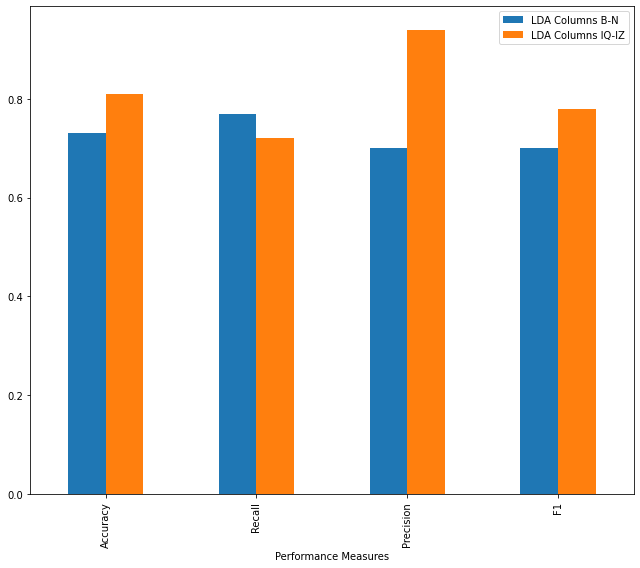

In [ ]:
# Plot LDA results for columns B-N and IQ-IZ
bayes_results.plot(x="Performance Measures", y=["LDA Columns B-N", "LDA Columns IQ-IZ"], kind="bar", figsize=(9, 8))

The above chart shows the various performance measures for columns B-N and columns IQ-IZ using LDA. The chart indicates that LDA was able to better predict class R in the columns B-N but better predicted other performance measures for columns IQ-IZ. This could be as a result of a wider spread of the values in columns IQ-IZ as compared to columns B-N.

### **QDA PERFORMANCE**

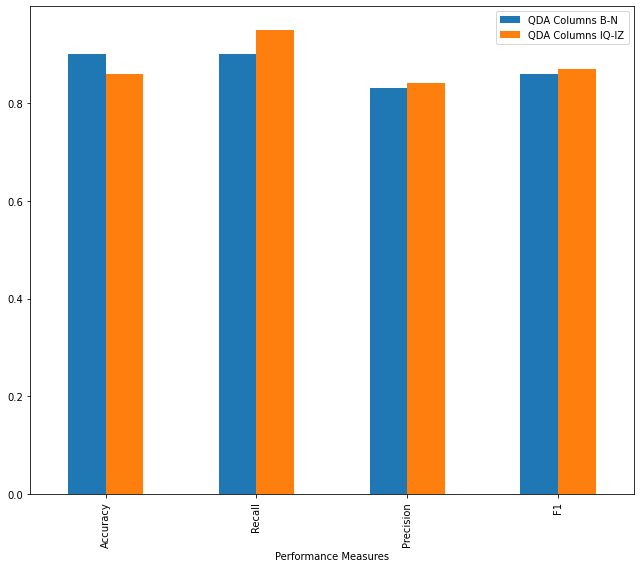

In [ ]:
# Plot LDA results for columns B-N and IQ-IZ
bayes_results.plot(x="Performance Measures", y=["QDA Columns B-N", "QDA Columns IQ-IZ"], kind="bar", figsize=(9, 8))

The above chart shows the various performance measures for columns B-N and columns IQ-IZ using QDA. The chart indicates that QDA was generally able to correctly predict class R and NR in the columns B-N but better predicted other performance measures for columns IQ-IZ.

### **PERFORMANCE OF LDA VS QDA**

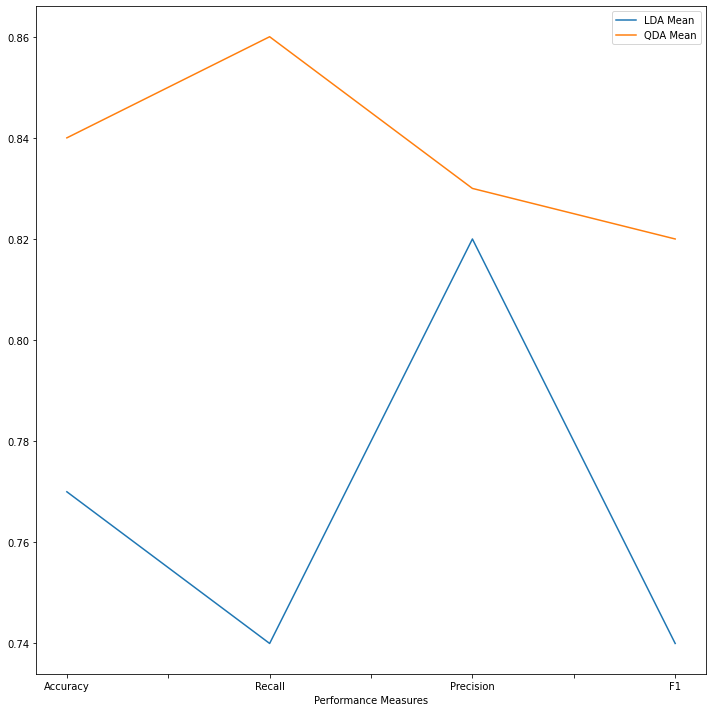

In [ ]:
# plot multiple columns such as population and year from dataframe
bayes_results.plot(x="Performance Measures", y=["LDA Mean", "QDA Mean"],
        kind="line", figsize=(10, 10))

The above chart shows the variation of mean performance measures of LDA and QDA. It can be seen that QDA outperforms LDA accross all performance measures used in this analysis.

### **NORMALIZATION FOR LDA AND QDA**

During this analysis, it was experimented and proven to be true that LDA results for standardized and non-standardized features are exactly thesame. Due to this, the data was not normalized for both LDA and QDA because their comparison will be biased.

## **PRINCIPAL COMPONENT ANALYSIS (PCA) FOR DATA VISUALIZATION**

PCA is an unsupervised learning method that can be used to project high dimensional data to lower dimensions by simplifying its complexities. This means that it finds patterns without reference to prior knowledge about whether the samples come from different samples or not. The first principal component is chosen to minimize the total distance between the data and their projection onto the principal component. By minimizing this distance, the variance of the projected points is also maximized. Subsequent principal component(s) are selected similarly, with the additional requirement that they be uncorrelated with all previous PCs.

The dimension of data used in this analysis is high, so PCA was used to reduce the dimensions to two and three.

### **DATA STANDARDIZATION**

PCA yields a feature subspace that maximizes the variance along the axes. Therefore, the data needs to be standardized. This involves transforming the data onto unit scale (mean = 0 and variance = 1).

### **COLUMN B-N 2D & 3D PROJECTION**

In [ ]:
# Get PCA and explained variance for columns IQ-IZ
principalDf, total_var= pca(all_files_bn, 'Label', 3)

# Rename target values to former R and NR
# Dictionary for binary values to the target feature 'Label'
cleanup_nums = {"Target":     {0: 'R', 1: 'NR'}}
# Convert the values to numbers using replace
principalDf = principalDf.replace(cleanup_nums)
principalDf

,Target,Principal component 1,Principal component 2,Principal component 3
0,R,-0.555166,-0.039566,1.303552
1,R,5.106655,0.373076,-0.874398
2,R,-1.632794,0.675042,0.273607
3,R,-1.967707,-0.743595,-1.188220
4,R,0.042071,2.710701,0.907784
5,R,-1.967707,-0.743595,-1.188220
6,R,-1.632794,0.675042,0.273607
7,R,-1.015203,0.165906,1.362899
8,R,5.106655,0.373076,-0.874398
9,R,5.106655,0.373076,-0.874398


In [ ]:
# Visualize PCA for 2D
visualize_xD(principalDf, total_var, 'Target', 2)

In [ ]:
# Visualize PCA for 3D
visualize_xD(principalDf, total_var, 'Target', 3)

### **COLUMN IQ-IZ 2D & 3D PROJECTION**

In [ ]:
# Get PCA and explained variance for columns IQ-IZ
principalDf, total_var= pca(all_files_qz_mean, 'Label', 3)

# Rename target values to former R and NR
# Dictionary for binary values to the target feature 'Label'
cleanup_nums = {"Target":     {0: 'R', 1: 'NR'}}
# Convert the values to numbers using replace
principalDf = principalDf.replace(cleanup_nums)
principalDf

Total Explained Variance:   86.53


,Target,Principal component 1,Principal component 2,Principal component 3
0,R,-1.835146,-0.746770,0.290835
1,R,0.987144,2.627673,-1.198852
2,R,-1.835146,-0.746770,0.290835
3,R,2.014399,0.129032,0.014720
4,R,2.014399,0.129032,0.014720
5,R,-0.944194,-0.452921,0.011454
6,R,1.577075,1.770211,1.038363
7,R,1.577075,1.770211,1.038363
8,R,1.857836,-3.006865,-0.168420
9,R,0.942986,-0.281313,-0.256535


In [ ]:
# Visualize PCA for 2D
visualize_xD(principalDf, total_var, 'Target', 2)

In [ ]:
# Visualize PCA for 3D
visualize_xD(principalDf, total_var, 'Target', 3)

### **COLUMNS B-N VS COLUMNS IQ-IZ**

Through the 2D and 3D visualizations of each column group, it can be observed that the points can be better differentiated non-linearly into classes R and NR, and this is why QDA outperformed LDA. The 3D projections of both classes also shows better class differentiation in columns IQ-IZ than in columns B-N, which can also be seen in the comparison of both column groups for LDA and QDA in the previous section.

## **CONCLUSION**


The hypothesis can be accepted and the null hypothesis discarded because QDA did outperform LDA in the classification of the dataset into classes R and NR. Also, normalization of dataset used in LDA does not improve the model in anyway. In fact, the model yields exactly the same result.

The attributes of grouped data and attributes generated when concatenated with other grouped data are very different. When concatenated, values of some groups may seem to be outliers when they are not in their individual groups.

In conclusion, this analysis can be further extended to include the normalization of data used for QDA to observe positive or negative change to the model's performance measures.